# Movie Reviews Sentiment Analysis
## Dataset
The used dataset is the [Sentiment polarity datasets v2.0](http://www.cs.cornell.edu/people/pabo/movie-review-data/). The dataset contains 1000 positive and 1000 negative processed reviews that is stored in the `review_polarity` folder.

- Inside the `review_polarity` folder, `txt_sentoken` contains 2000 processed down-cased text files, seperated into to category sub-folder, namely `neg` (i.e. negative) and `pos` (i.e. positive). Each sub-folder contains 1000 review text files in that category. 

- `poldata.README.2.0` stores all the meta information of this dataset.

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# scikit-learn
from sklearn.datasets import load_files  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

# nltk
from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from itertools import chain
from nltk.stem import WordNetLemmatizer
from nltk.probability import *
from nltk.util import ngrams

## 1. Import Data

Import the data using [**load_files**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html).
The loaded `movie_data` is a dictionary, with the following attributes:
* `data` - a list of text reviews
* `target` - the corresponding label of the text reviews (integer index)
* `target_names` - the names of target classes.
* `filenames` - the filenames holding the dataset.

In [6]:
movie_data = load_files(r"review_polarity/txt_sentoken")  

In [7]:
movie_data['filenames']

array(['review_polarity/txt_sentoken/neg/cv677_18938.txt',
       'review_polarity/txt_sentoken/neg/cv980_11851.txt',
       'review_polarity/txt_sentoken/pos/cv239_3385.txt', ...,
       'review_polarity/txt_sentoken/pos/cv652_13972.txt',
       'review_polarity/txt_sentoken/neg/cv559_0057.txt',
       'review_polarity/txt_sentoken/neg/cv684_12727.txt'], dtype='<U48')

In [8]:
movie_data['target']

array([0, 0, 1, ..., 1, 0, 0])

In [9]:
movie_data['target_names']

['neg', 'pos']

In [10]:
# test whether it matches
emp = 10 # an example
movie_data['filenames'][emp], movie_data['target'][emp] # from the file path we know that it's the correct class

('review_polarity/txt_sentoken/pos/cv267_14952.txt', 1)

#### Define reviews and sentiments

In [12]:
reviews = movie_data.data

sentiments= movie_data.target  

In [13]:
reviews[emp]

b'while it was part of former yugoslavia , my country , croatia , used to be almost completely ignored by western films in general . \nwords " croatia " and " croatians " were unheard , even in movies whose plots actually took place on croatian locations . \nthe rare exception was the dogs of war , 1980 adaptation of frederick forsyth\'s bestselling novel , yet that rare occasion only added insult to the injury , by mentioning croatians in most unflattering context . \nin a single line they are referred as a bunch of mean people , probably terrorists , who happen to remove parts of arm dealers\' stomachs when they are unsatisfied with the quality of merchandise . \nsame line also illustrates the milieu where the movie takes place - dark and violent world of shady international deals with the blurred boundaries between business , politics and crime . \nthe movie protagonist , shannon ( christopher walken ) is a mercenary who spent the best years of his life fighting numerous little wars

In [14]:
sentiments[emp]

1

## 2. Text Preprocessing

### 2.1. Tokenization

> Each review text is read as a byte object (see there is a `b` in front of each review text if you print it out), however, the tokenizer cannot apply a string pattern on a bytes-like object. To resolve this, each review text is decoded with 'utf-8'


#### Utilities

In [18]:
def tokenizeReview(raw_review):
    """
        This function first convert all words to lowercases, 
        it then segment the raw review into sentences and tokenize each sentences 
        and convert the review to a list of tokens.
    """        
    review = raw_review.decode('utf-8') # convert the bytes-like object to python string, need this before we apply any pattern search on it
    nl_review = review.lower() # cover all words to lowercase
    
    # segament into sentences
    sentences = sent_tokenize(review)
    
    # tokenize each sentence
    pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Za-z]\.)+        # abbreviations, e.g. U.S.A.
      #| \w*[\$£]?(?:\d+(?:,\d+)?)+(?:\.\d+)?%?\w*  # numbers, currency and percentages, e.g. $12.40, 82%
      | [A-Za-z]+(?:[-'][A-Za-z]*)?        # words with optional internal hyphens and apostrophes
    '''
    tokenizer = RegexpTokenizer(pattern) 
    token_lists = [tokenizer.tokenize(sen) for sen in sentences]
    
    # merge them into a list of tokens
    tokenised_review = list(chain.from_iterable(token_lists))
    return tokenised_review

In [19]:

def stats_print(tk_reviews):
    words = list(chain.from_iterable(tk_reviews)) # we put all the tokens in the corpus in a single list
    vocab = set(words) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words
    lexical_diversity = len(vocab)/len(words)
    print("Vocabulary size: ",len(vocab))
    print("Total number of tokens: ", len(words))
    print("Lexical diversity: ", lexical_diversity)
    print("Total number of reviews:", len(tk_reviews))
    lens = [len(article) for article in tk_reviews]
    print("Average review length:", np.mean(lens))
    print("Maximun review length:", np.max(lens))
    print("Minimun review length:", np.min(lens))
    print("Standard deviation of review length:", np.std(lens))

#### Tokenize reviews

In [21]:
tk_reviews = [tokenizeReview(r) for r in reviews] 

In [22]:
print("Raw review:\n",reviews[emp],'\n')
print("Tokenized review:\n",tk_reviews[emp])

Raw review:
 b'while it was part of former yugoslavia , my country , croatia , used to be almost completely ignored by western films in general . \nwords " croatia " and " croatians " were unheard , even in movies whose plots actually took place on croatian locations . \nthe rare exception was the dogs of war , 1980 adaptation of frederick forsyth\'s bestselling novel , yet that rare occasion only added insult to the injury , by mentioning croatians in most unflattering context . \nin a single line they are referred as a bunch of mean people , probably terrorists , who happen to remove parts of arm dealers\' stomachs when they are unsatisfied with the quality of merchandise . \nsame line also illustrates the milieu where the movie takes place - dark and violent world of shady international deals with the blurred boundaries between business , politics and crime . \nthe movie protagonist , shannon ( christopher walken ) is a mercenary who spent the best years of his life fighting numerou

In [23]:
stats_print(tk_reviews)

Vocabulary size:  48639
Total number of tokens:  1291842
Lexical diversity:  0.037650889195427924
Total number of reviews: 2002
Average review length: 645.2757242757243
Maximun review length: 2366
Minimun review length: 16
Standard deviation of review length: 286.01108817236855


### 2.2. Removing Single Character Token


In [25]:
st_list = [[w for w in review if len(w) <= 1 ] for review in tk_reviews] # create a list of single character token for each review
list(chain.from_iterable(st_list)) # merge them together in one list

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'i',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'a',
 'i',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'i',
 'r',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 's',
 'a',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 's',
 'i',
 'a',
 'a',
 'i',
 'a',
 'a',
 'i',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 's',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 's',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a'

In [26]:
# filter out single character tokens
tk_reviews = [[w for w in review if len(w) >=2] for review in tk_reviews]

In [27]:
# check whether the single character token has been removed
print("Tokenized review:\n",tk_reviews[emp])

Tokenized review:
 ['while', 'it', 'was', 'part', 'of', 'former', 'yugoslavia', 'my', 'country', 'croatia', 'used', 'to', 'be', 'almost', 'completely', 'ignored', 'by', 'western', 'films', 'in', 'general', 'words', 'croatia', 'and', 'croatians', 'were', 'unheard', 'even', 'in', 'movies', 'whose', 'plots', 'actually', 'took', 'place', 'on', 'croatian', 'locations', 'the', 'rare', 'exception', 'was', 'the', 'dogs', 'of', 'war', 'adaptation', 'of', 'frederick', "forsyth's", 'bestselling', 'novel', 'yet', 'that', 'rare', 'occasion', 'only', 'added', 'insult', 'to', 'the', 'injury', 'by', 'mentioning', 'croatians', 'in', 'most', 'unflattering', 'context', 'in', 'single', 'line', 'they', 'are', 'referred', 'as', 'bunch', 'of', 'mean', 'people', 'probably', 'terrorists', 'who', 'happen', 'to', 'remove', 'parts', 'of', 'arm', "dealers'", 'stomachs', 'when', 'they', 'are', 'unsatisfied', 'with', 'the', 'quality', 'of', 'merchandise', 'same', 'line', 'also', 'illustrates', 'the', 'milieu', 'wher

### 2.3. Removing Stop words
Get English `stopwords` from `ntlk`

In [29]:
stopwords = stopwords.words('english')

Ignore **negative** stopwords

In [31]:
ignored_words = [w for w in stopwords if not ("not" in w or "n't" in w or "no" in w)]

In [32]:
# filter out stop words
tk_reviews = [[w for w in review if w not in ignored_words] for review in tk_reviews]

In [33]:
# examine the reviews stat
stats_print(tk_reviews)

Vocabulary size:  48468
Total number of tokens:  713889
Lexical diversity:  0.06789290772094822
Total number of reviews: 2002
Average review length: 356.5879120879121
Maximun review length: 1392
Minimun review length: 8
Standard deviation of review length: 154.5078277786966


### 2.4. Stemming and Lemmatization
Use`WordNet` for lemmatization 

In [35]:
words = list(chain.from_iterable(tk_reviews)) 
vocab = set(words) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words

In [36]:
lemmatizer = WordNetLemmatizer()

# examine the lemmatizer first
ch_list = ['{0} -> {1}'.format(w, lemmatizer.lemmatize(w)) for w in vocab if w!=lemmatizer.lemmatize(w)]
print(len(ch_list))
ch_list

5132


['claws -> claw',
 'composers -> composer',
 'religions -> religion',
 'ingredients -> ingredient',
 'murderers -> murderer',
 'tops -> top',
 'beginnings -> beginning',
 'huns -> hun',
 'duties -> duty',
 'weapons -> weapon',
 'morals -> moral',
 'assassins -> assassin',
 'tvs -> tv',
 'knocks -> knock',
 'crusades -> crusade',
 'rows -> row',
 'kennedys -> kennedy',
 'romanovs -> romanov',
 'rats -> rat',
 'monks -> monk',
 'fornicators -> fornicator',
 'clamps -> clamp',
 'exceptions -> exception',
 'gangstas -> gangsta',
 'aires -> aire',
 'exaggerations -> exaggeration',
 'threads -> thread',
 'diversions -> diversion',
 'guests -> guest',
 'declines -> decline',
 'resolves -> resolve',
 'inputs -> input',
 'details -> detail',
 'cheats -> cheat',
 'viewings -> viewing',
 'managers -> manager',
 'goblins -> goblin',
 'streams -> stream',
 'wormwoods -> wormwood',
 'hrs -> hr',
 'criticisms -> criticism',
 'toys -> toy',
 'flushes -> flush',
 'slimes -> slime',
 'suitors -> suitor'

In [37]:
# lemmatize each review
tk_reviews = [[lemmatizer.lemmatize(w) for w in review] for review in tk_reviews]

In [38]:
stats_print(tk_reviews)

Vocabulary size:  44130
Total number of tokens:  713889
Lexical diversity:  0.06181633279123225
Total number of reviews: 2002
Average review length: 356.5879120879121
Maximun review length: 1392
Minimun review length: 8
Standard deviation of review length: 154.5078277786966


## 3. Text Representation 

### 3.1. Most and Less Frequent Words

In [41]:
# get new bag of words after preprocessing
words = list(chain.from_iterable(tk_reviews)) 

#### 3.1.1. Most Frequent Words

##### Most Frequent Words in Single Terms
Examine words frequency in terms of *words appearance across the data*.

In [44]:
term_fd = FreqDist(words)

In [45]:
term_fd.most_common(25)

[('film', 10379),
 ('movie', 6622),
 ('one', 5709),
 ('not', 5531),
 ('character', 3716),
 ('like', 3658),
 ('time', 2851),
 ('get', 2785),
 ('scene', 2648),
 ('make', 2584),
 ('even', 2558),
 ('no', 2414),
 ('good', 2340),
 ('story', 2289),
 ('would', 2043),
 ('much', 2024),
 ('also', 1965),
 ('see', 1864),
 ('way', 1856),
 ('two', 1827),
 ('life', 1813),
 ('first', 1768),
 ('go', 1723),
 ('well', 1669),
 ('thing', 1651)]

##### Most Frequent Words in Documents
Examine words frequency in term of documents appearance (count the reviews that include the words)

In [47]:
words_2 = list(chain.from_iterable([set(review) for review in tk_reviews]))
doc_fd = FreqDist(words_2)  # compute document frequency for each unique word/type
doc_fd.most_common(25)

[('film', 1772),
 ('one', 1760),
 ('not', 1672),
 ('movie', 1630),
 ('like', 1491),
 ('character', 1412),
 ('time', 1382),
 ('get', 1317),
 ('make', 1309),
 ('even', 1291),
 ('no', 1189),
 ('scene', 1166),
 ('good', 1156),
 ('much', 1128),
 ('would', 1113),
 ('story', 1091),
 ('way', 1073),
 ('also', 1070),
 ('go', 1037),
 ('two', 1025),
 ('first', 1019),
 ('see', 1015),
 ('well', 991),
 ('take', 983),
 ('come', 967)]

Examine the most **frequent words in both observation**

In [49]:
tf_words = set(w[0] for w in term_fd.most_common(25))
df_words = set(w[0] for w in doc_fd.most_common(25))

tf_words.union(df_words)

{'also',
 'character',
 'come',
 'even',
 'film',
 'first',
 'get',
 'go',
 'good',
 'life',
 'like',
 'make',
 'movie',
 'much',
 'no',
 'not',
 'one',
 'scene',
 'see',
 'story',
 'take',
 'thing',
 'time',
 'two',
 'way',
 'well',
 'would'}

In [50]:
# words are most frequent based on term frequence, but not document frequence
tf_words.difference(df_words)

{'life', 'thing'}

In [51]:
# words are most frequent based on document frequence, but not term frequence
df_words.difference(tf_words)

{'come', 'take'}

These words seem to **indicates the sentiment** => they are reasonably kept.

#### 3.1.2. Less Frequent Words

In [54]:
lessFreqWords = set(term_fd.hapaxes())
lessFreqWords

{"total'",
 "generation's",
 'scharzenegger',
 'prince-like',
 'boone-type',
 'dulled',
 'wedged',
 'vanguard',
 'netting',
 'egotism',
 'patrolled',
 'paup',
 'drug-kingpins',
 'brush-up',
 'blackwell',
 'gun-',
 'quasi-incestuous',
 'arcand',
 'limburgher',
 'noisily',
 'sneaky-smart',
 'hollywoodized',
 'stockpiling',
 'bloodier',
 'trickiest',
 'sommelier',
 'irrefutable',
 'unthankfully',
 'inefficiency',
 'willful',
 'low-quality',
 "huang's",
 'monsoon',
 'trapper',
 'crossbow',
 'chainsaw-massacre',
 'cleanest',
 'sigh-inducing',
 'evne',
 'impressive-as',
 'window-shopping',
 "stricter's",
 're-occurring',
 'biggie',
 'killed-a',
 'midwife',
 'remembers-',
 'luketic',
 'reproduced',
 'altruist',
 'harsh-reality',
 'mish-mash',
 'pimple-faced',
 'demonstrator',
 'swish',
 "whedon's",
 'obesity',
 'karate-kicking',
 'personal-',
 'renograde',
 'hambling',
 'embroils',
 'photosensitivity',
 'viscously',
 'shannen',
 'metabolism',
 'co-directed',
 'caffeinated',
 'palmieri',
 'thr

In [55]:
len(lessFreqWords)

18933

These words do not represent the sentiment => removable

In [57]:
def removeLessFreqWords(review): 
    return [w for w in review if w not in lessFreqWords]

In [58]:
tk_reviews = [removeLessFreqWords(review) for review in tk_reviews]

In [59]:
stats_print(tk_reviews)

Vocabulary size:  25197
Total number of tokens:  694956
Lexical diversity:  0.036256971664393144
Total number of reviews: 2002
Average review length: 347.13086913086914
Maximun review length: 1329
Minimun review length: 8
Standard deviation of review length: 150.9827244192884


### 3.2. Bigrams

In [61]:
bigrams = ngrams(words, n = 2)
fdbigram = FreqDist(bigrams)

In [62]:
bigrams = fdbigram.most_common(25) # top 25 bigrams
bigrams

[(('special', 'effect'), 388),
 (('look', 'like'), 257),
 (('new', 'york'), 244),
 (('even', 'though'), 222),
 (('no', 'one'), 194),
 (('bad', 'guy'), 184),
 (('high', 'school'), 175),
 (('film', 'like'), 171),
 (("i'm", 'not'), 171),
 (('take', 'place'), 169),
 (('film', 'not'), 164),
 (('star', 'war'), 159),
 (('one', 'best'), 141),
 (('main', 'character'), 135),
 (('horror', 'film'), 133),
 (('movie', 'like'), 131),
 (('one', 'thing'), 130),
 (('action', 'film'), 128),
 (('science', 'fiction'), 126),
 (('not', 'even'), 126),
 (('year', 'old'), 124),
 (("don't", 'know'), 123),
 (('movie', 'not'), 121),
 (('action', 'sequence'), 120),
 (('year', 'ago'), 120)]

In [63]:
rep_patterns = [" ".join(bg[0]) for bg in bigrams]
rep_patterns

['special effect',
 'look like',
 'new york',
 'even though',
 'no one',
 'bad guy',
 'high school',
 'film like',
 "i'm not",
 'take place',
 'film not',
 'star war',
 'one best',
 'main character',
 'horror film',
 'movie like',
 'one thing',
 'action film',
 'science fiction',
 'not even',
 'year old',
 "don't know",
 'movie not',
 'action sequence',
 'year ago']

`film like`,`film not`,`movie like`,`movie not` do not bear any signifcant meanings => **removable**

In [65]:
filtered = ['film like','film not','movie like','movie not'] # define a list of bigrams that we won't include
rep_patterns = [bg for bg in rep_patterns if bg not in filtered] # create a list of bigrams that we want to include
rep_patterns

['special effect',
 'look like',
 'new york',
 'even though',
 'no one',
 'bad guy',
 'high school',
 "i'm not",
 'take place',
 'star war',
 'one best',
 'main character',
 'horror film',
 'one thing',
 'action film',
 'science fiction',
 'not even',
 'year old',
 "don't know",
 'action sequence',
 'year ago']

In [66]:
# convert the format of bigram into word1_word2
replacements = [bg.replace(" ","_") for bg in rep_patterns]
replacements

['special_effect',
 'look_like',
 'new_york',
 'even_though',
 'no_one',
 'bad_guy',
 'high_school',
 "i'm_not",
 'take_place',
 'star_war',
 'one_best',
 'main_character',
 'horror_film',
 'one_thing',
 'action_film',
 'science_fiction',
 'not_even',
 'year_old',
 "don't_know",
 'action_sequence',
 'year_ago']

In [68]:
tk_reviews = [" ".join(review) for review in tk_reviews] # construct the review string

for i in range(0, len(tk_reviews)): 
    for j in range(0,len(rep_patterns)):
        tk_reviews[i] = re.sub(rep_patterns[j], replacements[j], tk_reviews[i]) # replace the bigram with the newly constructed representation 

tk_reviews = [review.split(" ") for review in tk_reviews] # convert back to tokenised review

In [69]:
stats_print(tk_reviews)

Vocabulary size:  25267
Total number of tokens:  691252
Lexical diversity:  0.036552516303750296
Total number of reviews: 2002
Average review length: 345.28071928071927
Maximun review length: 1327
Minimun review length: 7
Standard deviation of review length: 150.14967263929825


### 3.3. Bag of Words (Vocabulary)

In [71]:
words = list(chain.from_iterable(tk_reviews))
vocab = sorted(list(set(words))) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words

len(vocab)

25267

### 3.4. Feature Vectors
Generate feature vectors from tokenized review text.

In [73]:
# binding the words together for each review
joined_reviews = [' '.join(review) for review in tk_reviews]

#### 3.4.1. Binary Vectors

In [75]:
bVectorizer = CountVectorizer(analyzer = "word",binary = True,vocabulary = vocab)
binary_features = bVectorizer.fit_transform(joined_reviews)
binary_features.shape

/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1375: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


(2002, 25267)

#### 3.4.2. Count Vectors

In [77]:
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # initialised the CountVectorizer
count_features = cVectorizer.fit_transform(joined_reviews)
count_features.shape

(2002, 25267)

#### 3.4.3. TF-IDF Vectors

In [79]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform(joined_reviews) # generate the tfidf vector representation for all articles
tfidf_features.shape

(2002, 25267)

## 4. Sentiment Analysis Using Logistic Regression
Since there are only 2 sentiments ('neg' and 'pos') => binary classification algorithm is used, specifically, **Logistic Regression**.

Firstly, KFold (with 10 folds) is used to evaluate the models trained with 3 different vectorized features.

#### KFold Validation

In [82]:
def evaluate(X_train,X_test,y_train, y_test,seed):
    model = LogisticRegression(random_state=seed,max_iter = 1000)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test) # accuracy

In [83]:
seed = 15

# define the 10-fold
num_folds = 10
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True)

In [84]:
cv_df = pd.DataFrame(columns = ['binary','count','tfidf'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(sentiments)))):
    y_train = [str(sentiments[i]) for i in train_index]
    y_test = [str(sentiments[i]) for i in test_index]

    X_train_binary, X_test_binary = binary_features[train_index], binary_features[test_index]
    cv_df.loc[fold,'binary'] = evaluate(binary_features[train_index],binary_features[test_index],y_train,y_test,seed)
    
    X_train_count, X_test_count = count_features[train_index], count_features[test_index]
    cv_df.loc[fold,'count'] = evaluate(count_features[train_index],count_features[test_index],y_train,y_test,seed)

    X_train_tfidf, X_test_tfidf = tfidf_features[train_index], tfidf_features[test_index]
    cv_df.loc[fold,'tfidf'] = evaluate(tfidf_features[train_index],tfidf_features[test_index],y_train,y_test,seed)
    
    fold +=1

In [85]:
# examine the accuracy of each approach in 10 folds
cv_df

,binary,count,tfidf
0,0.915423,0.875622,0.850746
1,0.845771,0.810945,0.810945
2,0.83,0.83,0.86
3,0.905,0.905,0.865
4,0.87,0.86,0.86
5,0.845,0.815,0.84
6,0.845,0.835,0.825
7,0.84,0.795,0.83
8,0.84,0.835,0.855
9,0.845,0.845,0.82


In [86]:
# get the mean accuracy
cv_df.mean()

binary    0.858119
count     0.840657
tfidf     0.841669
dtype: object

**Logistic Regression with binary vectors** model achieved better accuracy overall.

#### Examine Logistic Regression with binary vectors 

##### Utilities

In [90]:
def train_and_report(model,  X_train, y_train, X_test, y_test, model_name="", grid=False):
    
    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Precision
            6. Recall
            7. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            8. AUROC Curve - Area Under the Receiver Operating Characteristic Curve

    Return Value: 
       trained model
    '''
    # Train the model
    model.fit(X_train, y_train)

    # Predict test set using the model
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1:]

    if grid == True:
        print(f'Best params for the model: {model.best_params_}')
    
    

    ##########

    # REPORT SECTION 
    # Report Title
    fig, axes = plt.subplots(2, 1, figsize = (8, 3))
    axes[0].text(9, 1.8, "Model Report", fontsize=30, horizontalalignment='center', 
                 color='DarkBlue', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    ##########
    
    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred)

    # Calculate the individual classification metric scores
    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ']
    
    model_f1_score = f1_score(y_test, y_pred)
    model_precision_score = precision_score(y_test, y_pred)
    model_recall_score = recall_score(y_test, y_pred)
    model_accuracy_score = accuracy_score(y_test, y_pred)
    model_auc_roc = auc(fpr, tpr)

    scores.append([model_f1_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc])

    ##########
    
    # Confusion Matrix
    conf_matx = confusion_matrix(y_test, y_pred)
    # display Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize = (20, 4))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left')

    ##########
    
    # Classification Metrics
    sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)
    
    # display Classification Metrics
    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic', 
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center')

    ##########
    
    # Classification Report
    class_report = classification_report(y_test, y_pred)
    # display Classification Report
    axes[2].text(0, 1, class_report, style='italic', fontsize=20)
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center')
    plt.tight_layout()
    plt.show()
    
    ##########

    # AUC-ROC Curve
    model_roc_auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize = (12.8 , 6))
    plt.plot(fpr, tpr, label = 'AUC = {})'.\
             format(model_roc_auc.round(4)))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = 'lower right')
    plt.show()

##### Examine

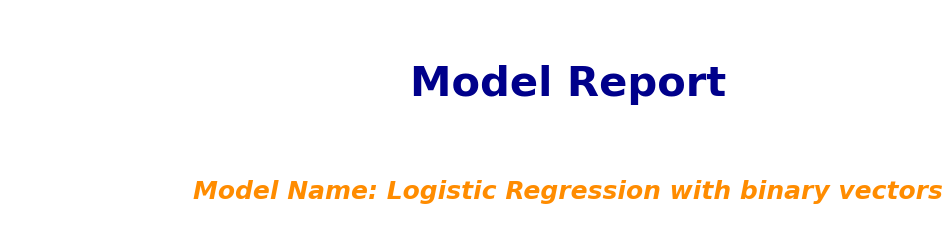

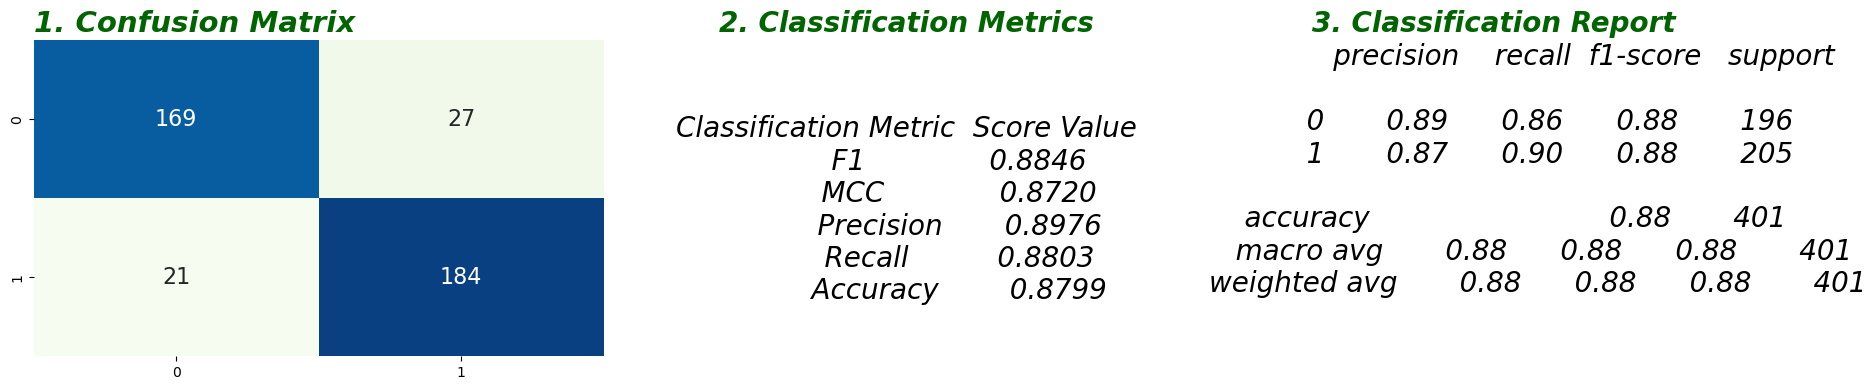

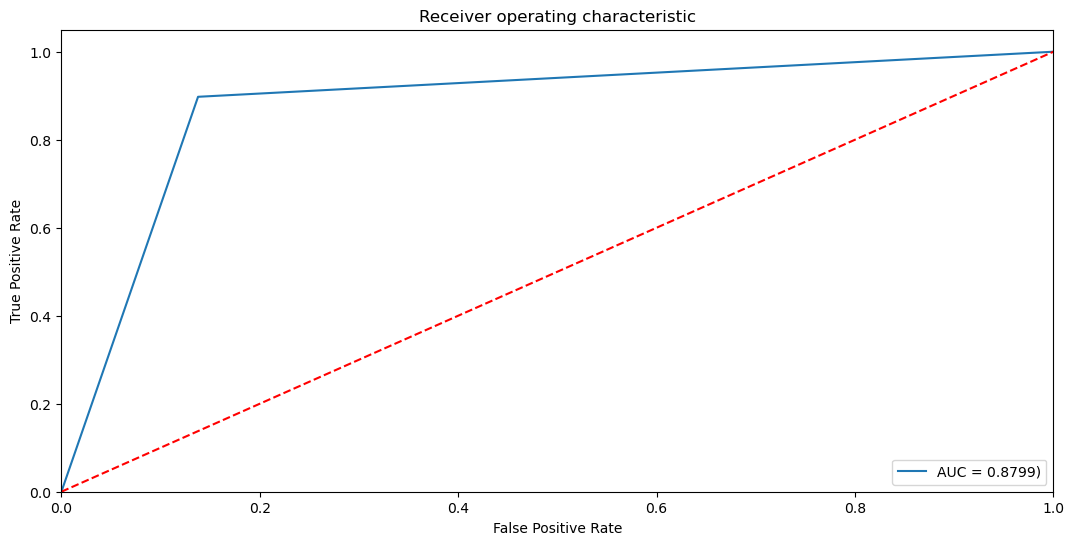

In [92]:
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(binary_features, sentiments, list(range(0,len(sentiments))),test_size=0.2, random_state=seed)

model = LogisticRegression(random_state=seed,max_iter=1000)

train_and_report(model, X_train, y_train, X_test, y_test, 'Logistic Regression with binary vectors')

The model achieves decent score and has high capability to analyse both 'positive'  and 'negative' reviews.